In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np

import scipy as scp
import sklearn
import sys, os, pickle

sys.path.append(os.path.join('..'))

from FACT.helper import *
from FACT.fairness import *
from FACT.data_util import *
from FACT.plot import *
from FACT.lin_opt import *

/Users/haewon/miniconda3/envs/FACT2/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from sklearn.model_selection import train_test_split

In [3]:
DATANAME='adult'
X_train, y_train, X_test, y_test, X_train_removed, X_test_removed, dtypes, dtypes_, sens_idc, race_idx, sex_idx = get_dataset(DATANAME)

In [4]:
X_train.shape, X_train_removed.shape, y_train.shape

((22792, 12), (22792, 10), (22792,))

In [5]:
try:
    #grid_base =  pickle.load(open('model_adult_base.pkl', 'rb'))[0]
    grid =  pickle.load(open('model_adult.pkl', 'rb'))[0]
    #model_base = grid_base.best_estimator_.named_steps['logisticregression']
    model = grid.best_estimator_.named_steps['logisticregression']
except:
    model_names = ['LogisticRegression']
    result = create_and_train_models(model_names, dtypes_, X_train_removed, y_train, X_test=X_test_removed, y_test=y_test, save=True, data_name=DATANAME)
    #result_base = create_and_train_models(model_names, dtypes, X_train, y_train, X_test=X_test, y_test=y_test, save=True, data_name=DATANAME + '_base')
    #model_base = result_base[0]['estimator']
    model = result[0]['estimator']

Training {'estimator': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(categorical_features=array([False, False, False, False,  True,  True,  True,  True,  True,
        True]),
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values='auto', sparse=False)), ('standardscaler', StandardScaler(copy=True, with_me...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'logisticregression__C': array([0.0001, 0.1   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0), 'get_model': <function create_model.<locals>.get_model at 0x7f9a219bad90>, 'model_name': 'LogisticRegression'}


In [6]:
# Get fairness matrix information
fm = FairnessMeasures(X_train, 
                      y_train, 
                      X_test, 
                      y_test, 
                      X_train_removed, 
                      X_test_removed, 
                      model, 
                      sex_idx, 
                      pos_label=1, 
                      neg_label=0)

mats, mats_dict, M_const, b_const = get_fairness_mats(fm)

In [7]:
tpr_diff, fpr_diff = fm.equalized_odds_diff()
meo = np.abs(tpr_diff + fpr_diff)/2
print(meo)

0.08295690591794794


In [8]:
result = test_all_enumerations(fm, mats)

['EqOdd', 'Calibration']	False	None
['EqOdd', 'PosClassBal']	True	0.23686779050537868
['EqOdd', 'NegClassBal']	True	0.23687069783024092
['EqOdd', 'ClassBal']	True	0.23686779050537812
['EqOdd', 'PredEqual']	True	0.23687069783024065
['EqOdd', 'EqOpp']	True	0.23687069783024622
['EqOdd', 'DemoParity']	True	0.23686670012609065
['Calibration', 'PosClassBal']	False	None
['Calibration', 'NegClassBal']	False	None
['Calibration', 'ClassBal']	False	None
['Calibration', 'PredEqual']	False	None
['Calibration', 'EqOpp']	False	None
['Calibration', 'DemoParity']	False	None
['PosClassBal', 'NegClassBal']	True	5.551115123125783e-16
['PosClassBal', 'ClassBal']	True	5.551115123125783e-16
['PosClassBal', 'PredEqual']	True	5.551115123125783e-16
['PosClassBal', 'EqOpp']	True	0.23686779050538145
['PosClassBal', 'DemoParity']	True	0.06537660169483518
['NegClassBal', 'ClassBal']	True	5.551115123125783e-16
['NegClassBal', 'PredEqual']	True	5.551115123125783e-16
['NegClassBal', 'EqOpp']	True	0.23687069783024262
[

In [9]:
# some_names = [['PosClassBal', 'ClassBal'], 
#               ['PredEqual', 'NegClassBal'],
#               ['EqOdd', 'DemoParity'],
#               ['EqOdd', 'PosClassBal', 'DemoParity'],
#               ['EqOdd', 'ClassBal', 'PredEqual', 'DemoParity'],
#               ['EqOdd', 'ClassBal', 'PredEqual', 'EqOpp', 'DemoParity'],
#               ['PosClassBal', 'DemoParity'], 
#               ['Calibration', 'ClassBal', 'EqOpp', 'DemoParity'],
#               ['PosClassBal', 'NegClassBal', 'Calibration'],
#              ]
some_names = [
    ['EqOdd']
]
dd = test_some_names(fm, some_names)
res2text(dd)

['EqOdd']	True	0.23687069783024334


'EOd &  o  & 0.7631\\ '

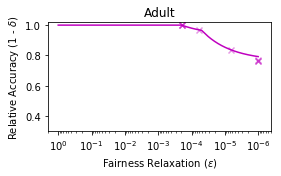

In [10]:
# First get (eps, delta) pairs for optimizing over different lambdas
lmbds_used = get_eps_delta_over_lambdas(mats_dict, M_const, b_const, some_names)

# NOTE manually set up the group for colors
groups = [0, 0, 1, 1, 1, 1, 2, 3, 4]
colors = ['m', 'b', 'g', 'r', 'k']
plot_eps_delta_curves(fm, 
                      some_names, 
                      lmbds_used, 
                      groups=groups, 
                      colors=colors, 
                      data_name='Adult',
                      save=True)

In [11]:
aaa = [2.87324470e-02, 1.73335318e-01, 8.53944736e-17, 4.66475586e-01, 6.56619941e-17, 3.48039717e-02, 2.37308452e-16, 2.96652677e-01]
tp1 = aaa[0]
fn1 = aaa[1]
fp1 = aaa[2]
tn1 = aaa[3]
tp0 = aaa[4]
fn0 = aaa[5]
fp0 = aaa[6]
tn0 = aaa[7]

tpr0 = tp0/(tp0+fn0)
tpr1 = tp1/(tp1+fn1)
fpr0 = fp0/(fp0+tn0)
fpr1 = fp1/(fp1+tn1)

tpr_diff = tpr0-tpr1
fpr_diff = fpr0-fpr1

meo = np.abs(tpr_diff + fpr_diff)/2
print(meo)


0.0710960676978822


In [12]:
acc, meo = accuracy_meo(fm, ['EqOdd'])

In [13]:
save = {
    'acc': acc,
    'meo': meo
}
savename = 'adult-FACT' +'.pkl'
with open(savename, 'wb+') as pickle_f:
    pickle.dump(save, pickle_f, 2)

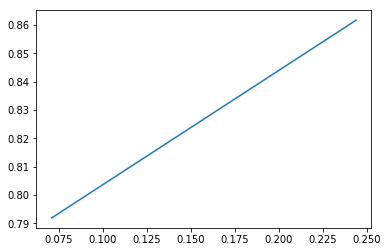

In [14]:
ct = 410
plt.plot(meo[ct:], acc[ct:])

In [78]:
adult = np.array([[0.06919340071379061, 0.8428703040229297],
[0.06857573548834281, 0.8426655747773569],
[0.06811610403899716, 0.8420513870406388],
[0.06811610403899718, 0.8422561162862114],
[0.06811610403899718, 0.8424608455317842],
[0.06811610403899718, 0.8418466577950661],
[0.06811610403899716, 0.8420513870406388],
[0.06811610403899718, 0.8418466577950661],
[0.06811610403899718, 0.8422561162862114],
[0.06811610403899719, 0.8416419285494933]])

In [79]:
adult.shape

(10, 2)

In [16]:
tpr_diff, fpr_diff = fm.equalized_odds_diff()
meo = np.abs(tpr_diff + fpr_diff)/2
print(meo)

0.08295690591794794


In [24]:
lmbds_used[0][0]

[0.0,
 1.0,
 17.78279410038923,
 316.22776601683796,
 5623.413251903491,
 100000.0,
 1778279.410038923]

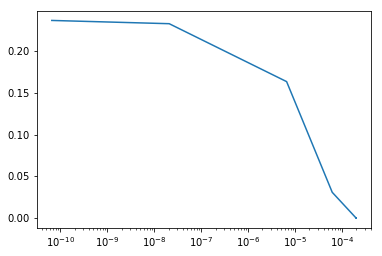

In [45]:
xxx = np.zeros((len(lmbds_used[0][1]),))
yyy = np.zeros((len(lmbds_used[0][1]),))
for i in range(len(lmbds_used[0][1])):
    yyy[i] = lmbds_used[0][1][i][0]
    xxx[i] = lmbds_used[0][1][i][1]
plt.semilogx(xxx, 1-yyy)

In [44]:
lmbds_used[0][1]

[(0.9999999999999994, 0.00019783889773088113),
 (0.9999999999999998, 0.0001978388977308827),
 (0.9999999999999994, 0.00019783889773088148),
 (0.969115667015989, 6.122739243120544e-05),
 (0.836590760512405, 6.5371581902049e-06),
 (0.7672561283512658, 2.0639952169656077e-08),
 (0.7633603712803313, 6.525884160411891e-11)]

In [10]:
def get_idx_wo_protected(feature_names, protected_attrs):
    idx_wo_protected = set(range(len(feature_names)))
    protected_attr_idx = [feature_names.index(x) for x in protected_attrs]
    idx_wo_protected = list(idx_wo_protected - set(protected_attr_idx))
    return idx_wo_protected

def get_idx_w_protected(feature_names):
    return list(set(range(len(feature_names))))

def get_idx_protected(feature_names, protected_attrs):
    protected_attr_idx = [feature_names.index(x) for x in protected_attrs]
    idx_protected = list(set(protected_attr_idx))
    return idx_protected

def load_data(name='adult'):
    
    #% Processing for UCI-ADULT
    if name == 'adult':
        file = '../data/UCI-Adult/adult.data'
        fileTest = '../data/UCI-Adult/adult.test'
        
        df = pd.read_csv(file, header=None,sep=',\s+',engine='python')
        dfTest = pd.read_csv(fileTest,header=None,skiprows=1,sep=',\s+',engine='python') 
        
        
        columnNames = ["age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "gender",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
        
        df.columns = columnNames
        dfTest.columns = columnNames
        
        df = df.append(dfTest)
        
        # drop columns that won't be used
        dropCol = ["fnlwgt","workclass","occupation"]
        df.drop(dropCol,inplace=True,axis=1)
        
        # keep only entries marked as ``White'' or ``Black''
        ix = df['race'].isin(['White','Black'])
        df = df.loc[ix,:]
        
        # binarize race
        # Black = 0; White = 1
        df.loc[:,'race'] = df['race'].apply(lambda x: 1 if x=='White' else 0)
        
        # binarize gender
        # Female = 0; Male = 1
        df.loc[:,'gender'] = df['gender'].apply(lambda x: 1 if x=='Male' else 0)
        
        # binarize income
        # '>50k' = 1; '<=50k' = 0
        df.loc[:,'income'] = df['income'].apply(lambda x: 1 if x[0]=='>' else 0)
        
        
        # drop "education" and native-country (education already encoded in education-num)
        features_to_drop = ["education","native-country"]
        df.drop(features_to_drop,inplace=True,axis=1)
        
        
        
        # create one-hot encoding
        categorical_features = list(set(df)-set(df._get_numeric_data().columns))
        df = pd.concat([df,pd.get_dummies(df[categorical_features])],axis=1,sort=False)
        df.drop(categorical_features,inplace=True,axis=1)
        
        # reset index
        df.reset_index(inplace=True,drop=True)
        
    
    #% Processing for COMPAS
    if name == 'compas':
        file = '../data/COMPAS/compas-scores-two-years.csv'
        df = pd.read_csv(file,index_col=0)
        
        # select features for analysis
        df = df[['age', 'c_charge_degree', 'race',  'sex', 'priors_count', 
                    'days_b_screening_arrest',  'is_recid',  'c_jail_in', 'c_jail_out']]
        
        # drop missing/bad features (following ProPublica's analysis)
        # ix is the index of variables we want to keep.

        # Remove entries with inconsistent arrest information.
        ix = df['days_b_screening_arrest'] <= 30
        ix = (df['days_b_screening_arrest'] >= -30) & ix

        # remove entries entries where compas case could not be found.
        ix = (df['is_recid'] != -1) & ix

        # remove traffic offenses.
        ix = (df['c_charge_degree'] != "O") & ix


        # trim dataset
        df = df.loc[ix,:]

        # create new attribute "length of stay" with total jail time.
        df['length_of_stay'] = (pd.to_datetime(df['c_jail_out'])-pd.to_datetime(df['c_jail_in'])).apply(lambda x: x.days)
        
        
        # drop 'c_jail_in' and 'c_jail_out'
        # drop columns that won't be used
        dropCol = ['c_jail_in', 'c_jail_out','days_b_screening_arrest']
        df.drop(dropCol,inplace=True,axis=1)
        
        # keep only African-American and Caucasian
        df = df.loc[df['race'].isin(['African-American','Caucasian']),:]
        
        # binarize race 
        # African-American: 0, Caucasian: 1
        df.loc[:,'race'] = df['race'].apply(lambda x: 1 if x=='Caucasian' else 0)
        
        # binarize gender
        # Female: 1, Male: 0
        df.loc[:,'sex'] = df['sex'].apply(lambda x: 1 if x=='Male' else 0)
        
        # rename columns 'sex' to 'gender'
        df.rename(index=str, columns={"sex": "gender"},inplace=True)
        
        # binarize degree charged
        # Misd. = -1, Felony = 1
        df.loc[:,'c_charge_degree'] = df['c_charge_degree'].apply(lambda x: 1 if x=='F' else -1)
               
        # reset index
        df.reset_index(inplace=True,drop=True)
        
        
    # TODO: add other datasets here
        
    return df

In [11]:
protected_attrs = ['race']
label_name = 'income'
use_protected = True
df = load_data(name='adult')

TypeError: concat() got an unexpected keyword argument 'sort'

In [18]:
dataset_orig_train, dataset_orig_test = train_test_split(df, test_size=0.3, random_state=0)

dataset_orig_train = StandardDataset(dataset_orig_train, label_name=label_name, favorable_classes=[1],
                                     protected_attribute_names=protected_attrs, privileged_classes=[[1]])
dataset_orig_test = StandardDataset(dataset_orig_test, label_name=label_name, favorable_classes=[1],
                                    protected_attribute_names=protected_attrs, privileged_classes=[[1]])


idx_features_w_pro = get_idx_w_protected(dataset_orig_train.feature_names)
idx_features_wo_pro = get_idx_wo_protected(dataset_orig_train.feature_names, protected_attrs)
idx_protected = get_idx_protected(dataset_orig_train.feature_names, protected_attrs)

X_train = dataset_orig_train.features[:, idx_features_w_pro]
X_train_removed = dataset_orig_train.features[:, idx_features_wo_pro]
y_train = dataset_orig_train.labels.ravel()
X_test = dataset_orig_test.features[:, idx_features_w_pro]
X_test_removed = dataset_orig_test.features[:, idx_features_wo_pro]
y_test = dataset_orig_test.labels.ravel()

s_train = dataset_orig_train.features[:, idx_protected].ravel()
s_test = dataset_orig_test.features[:, idx_protected].ravel()

In [22]:
X_train.shape

(32512, 20)

In [23]:
X_train_removed.shape

(32512, 19)

In [20]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train, sample_weight=dataset_orig_train.instance_weights)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(random_state=42)

In [ ]:
fm.equalized_odds_diff()

In [9]:
X_test.shape

(9769, 12)

In [6]:
result = test_all_enumerations(fm, mats)

['EqOdd', 'Calibration']	False	None
['EqOdd', 'PosClassBal']	True	0.23686779050539447
['EqOdd', 'NegClassBal']	True	0.23687069783024028
['EqOdd', 'ClassBal']	True	0.23686779050538861
['EqOdd', 'PredEqual']	True	0.2368706978302405
['EqOdd', 'EqOpp']	True	0.23687069783024559
['EqOdd', 'DemoParity']	True	0.23686669988716902
['Calibration', 'PosClassBal']	False	None
['Calibration', 'NegClassBal']	True	0.1492982386906257
['Calibration', 'ClassBal']	False	None
['Calibration', 'PredEqual']	True	0.1478210765505473
['Calibration', 'EqOpp']	False	None
['Calibration', 'DemoParity']	True	0.15080450909088844
['PosClassBal', 'NegClassBal']	True	5.551115123125783e-16
['PosClassBal', 'ClassBal']	True	5.551115123125783e-16
['PosClassBal', 'PredEqual']	True	5.551115123125783e-16
['PosClassBal', 'EqOpp']	True	0.23686779050538645
['PosClassBal', 'DemoParity']	True	0.06537660169483889
['NegClassBal', 'ClassBal']	True	5.551115123125783e-16
['NegClassBal', 'PredEqual']	True	5.551115123125783e-16
['NegClassBa

In [7]:
some_names = [['PosClassBal', 'ClassBal'], 
              ['PredEqual', 'NegClassBal'],
              ['EqOdd', 'DemoParity'],
              ['EqOdd', 'PosClassBal', 'DemoParity'],
              ['EqOdd', 'ClassBal', 'PredEqual', 'DemoParity'],
              ['EqOdd', 'ClassBal', 'PredEqual', 'EqOpp', 'DemoParity'],
              ['PosClassBal', 'DemoParity'], 
              ['Calibration', 'ClassBal', 'EqOpp', 'DemoParity'],
              ['PosClassBal', 'NegClassBal', 'Calibration'],
             ]
dd = test_some_names(fm, some_names)
res2text(dd)

['PosClassBal', 'ClassBal']	True	5.551115123125783e-16
['PredEqual', 'NegClassBal']	True	5.551115123125783e-16
['EqOdd', 'DemoParity']	True	0.23686669988716902
['EqOdd', 'PosClassBal', 'DemoParity']	True	0.2368682610345749
['EqOdd', 'ClassBal', 'PredEqual', 'DemoParity']	True	0.23686780488958686
['EqOdd', 'ClassBal', 'PredEqual', 'EqOpp', 'DemoParity']	True	0.23686625266408295
['PosClassBal', 'DemoParity']	True	0.06537660169483889
['Calibration', 'ClassBal', 'EqOpp', 'DemoParity']	True	0.15095048265751382
['PosClassBal', 'NegClassBal', 'Calibration']	False	None


'PCB, CB &  o  & 1.0000\\ PE, NCB &  o  & 1.0000\\ EOd, DP &  o  & 0.7631\\ EOd, PCB, DP &  o  & 0.7631\\ EOd, CB, PE, DP &  o  & 0.7631\\ EOd, CB, PE, EOp, DP &  o  & 0.7631\\ PCB, DP &  o  & 0.9346\\ CG, CB, EOp, DP &  o  & 0.8490\\ PCB, NCB, CG &  x  & -\\ '

Calibration,ClassBal,EqOpp,DemoParity	0.0013749172258064205
PosClassBal,NegClassBal,Calibration	0.00036401748474461414


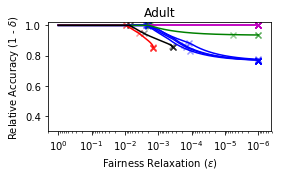

In [8]:
# First get (eps, delta) pairs for optimizing over different lambdas
lmbds_used = get_eps_delta_over_lambdas(mats_dict, M_const, b_const, some_names)

# NOTE manually set up the group for colors
groups = [0, 0, 1, 1, 1, 1, 2, 3, 4]
colors = ['m', 'b', 'g', 'r', 'k']
plot_eps_delta_curves(fm, 
                      some_names, 
                      lmbds_used, 
                      groups=groups, 
                      colors=colors, 
                      data_name='Adult',
                      save=True)

In [13]:
## try to compute acc and MEO
mats[0]

(array([[ 0.03480397,  0.        ,  0.        ,  0.        ,  0.20206777,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.29665268,  0.        ,  0.        ,
          0.        , -0.46647559,  0.        ]]), array([[0.],
        [0.]]), 'EqOdd')

In [19]:
mats_dict['EqOdd'][0][0]

array([0.03480397, 0.        , 0.        , 0.        , 0.20206777,
       0.        , 0.        , 0.        ])

In [20]:
mats_dict['EqOdd'][0][1]

array([ 0.        ,  0.        ,  0.29665268,  0.        ,  0.        ,
        0.        , -0.46647559,  0.        ])

(0.10373681387448597, 0.06217699796140991)

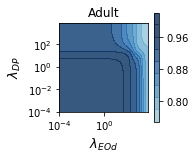

In [9]:
# Multi-dimensional regularization for fairness definitions:
name = ['EqOdd', 'DemoParity']
a, b = plot_accuracy_contours(mats_dict, 
                       name, 
                       M_const, 
                       b_const, 
                       bound=(4,4),
                       data_name='Adult',
                       save=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f19dc3323c8>,
      dtype=object)

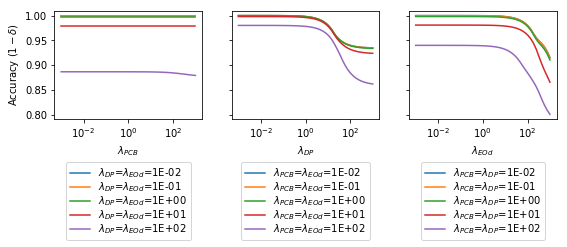

In [17]:
## Orderings
# NOTE place in the order of adding to the rest.
list_name = ['PosClassBal', 'DemoParity', 'EqOdd']
plot_slices(mats_dict, list_name, M_const, b_const, save=True, data_name='Adult')